In [ ]:
 Sys.cpu_info()

2-element Vector{Base.Sys.CPUinfo}:
 Intel(R) Xeon(R) CPU @ 2.20GHz: 
        speed         user         nice          sys         idle          irq
     2199 MHz        454 s          0 s        150 s        969 s          0 s
 Intel(R) Xeon(R) CPU @ 2.20GHz: 
        speed         user         nice          sys         idle          irq
     2199 MHz        416 s          0 s        142 s       1010 s          0 s

In [ ]:
import Pkg
Pkg.add("LinearAlgebra")
Pkg.add("SparseArrays")
Pkg.add("BandedMatrices")
Pkg.add("Statistics")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [37e2e46d] + LinearAlgebra
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.10/Project.toml`
  [2f01184e] + SparseArrays v1.10.0
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`
   Resolving package versions...
   Installed ArrayLayouts ─── v1.11.1
   Installed BandedMatrices ─ v1.9.4
    Updating `~/.julia/environments/v1.10/Project.toml`
  [aae01518] + BandedMatrices v1.9.4
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [4c555306] + ArrayLayouts v1.11.1
  [aae01518] + BandedMatrices v1.9.4
Precompiling packages...
  18016.2 ms  ✓ ArrayLayouts
   1699.3 ms  ✓ ArrayLayouts → ArrayLayoutsSparseArraysExt
  32088.5 ms  ✓ BandedMatrices
   2770.6 ms  ✓ ArrayInterface → ArrayInterfaceBandedMatricesExt
   3075.8 ms  ✓ BandedMatrices → Band

In [ ]:
using LinearAlgebra
using SparseArrays
using BandedMatrices
using Statistics
using Plots
using LaTeXStrings
using BenchmarkTools

# Structure-aware dispatch: General approach

---

Structure-aware dispatch approach consist of 3 steps:
  1. Identify appropiate algorithm and data format based on the input data.
  2. Convert data format if beneficial.
  3. Execute specialized algorithm.

Computationals costs:
- I: cost of structure identification
- f: cost of data format conversion
- f: cost of specialized algorithm
- F: cost of default algorithm
- N: size of the problem

**Speedup condition**: I(N) + C(N) + f(N) < F(N)
- If satisfied: **Speedup** = $\frac{F(N)}{I(N) + C(N) + f(N)}$

**Slowdown condition**: I(N) + F(N) ~ F(N)
- If satisfied: **Slowdown** = $\frac{I(N) + F(N)}{F(N)}$


# Structured Matrices Stored in Dense Formats

---


If the matrix is indeed structured, it is then converted to a structured data format, allowing the use of a specialized structured solver instead of a dense one.

## Opportunities for LU

- F: DGETRF ~ O(N^3)
- I: banded_structure ~ O(N^2)
- C: BandedMatrix ~ O(N^2)
- f: DGBTRF ~ O(N) to O(N^3)

**Speedup**
- Speedup condition is satisfied
  - I(N) + C(N) + f(N) < F(N) => O(N^2) + O(N^2) + O(N) < O(N^3)
- Maximum Speedup ~ F(N) / (I(N) + C(N) + f(N)) ~  O(N))

**Slowdown**
- Minimum slowdown condition is satisfied
  - I(N) + F(N) ~ F(N) => O(N^2) + O(N^3) ~  O(N^3)
- Slowdown ~ (O(N^2) + O(N^3)) / O(N^3) ~ O(1)

In [ ]:
I(N) = N^2
C(N) = N^2
f_lower(N) = N # lower bound
f_upper(N) = N^3 # upper bound
F(N) = N^3

ICf_lower(N) = I(N) + C(N) + f_lower(N)
ICf_upper(N) = I(N) + C(N) + f_upper(N)

Ns = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
ICf_lower_bounds = ICf_lower.(Ns)
ICf_upper_bounds = ICf_upper.(Ns)

1-element Vector{Any}:
 [4608, 34816, 270336, 2129920, 16908288, 134742016, 1075838976, 8598323200, 68753031168, 549890031616]

### Number of operations: lower and upper bounds

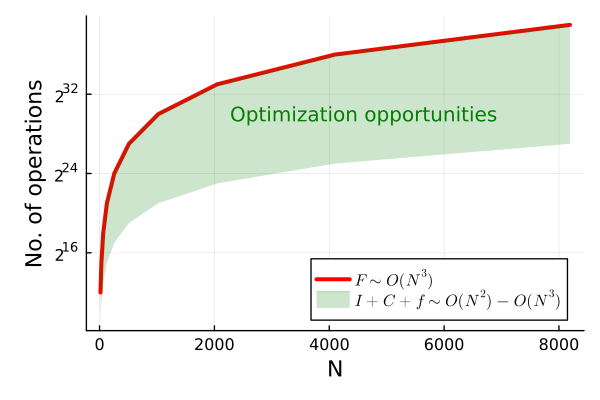

In [ ]:
# Plot number of operations
plot(Ns, F.(Ns), label=L"F \sim O(N^3)", color=:red, linewidth=3)
plot!(Ns, ICf_upper_bounds; fillrange=ICf_lower_bounds,
      label=L"I+C+f \sim O(N^2)-O(N^3)", color=:green, alpha=0.2)
plot!(xlabel="N", ylabel="No. of operations", yscale=:log2,
      legend=:bottomright, thickness_scaling = 1.35)
txt = Plots.text("Optimization opportunities", :green, 10)
annotate!([4600],[2^30],[txt])

### Maximum Speedup

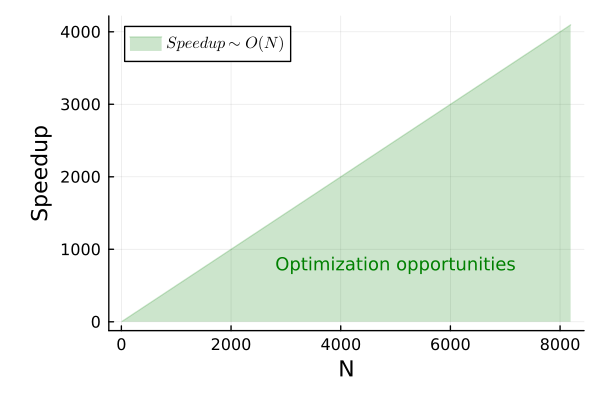

In [ ]:
Ns = [16, 32, 64, 128, 256, 512, 1024, 2048, 4096, 8192]
plot()

speedup_lower = F.(Ns) ./ ICf_upper_bounds
speedup_upper = F.(Ns) ./ ICf_lower_bounds
plot!(Ns, speedup_upper; fillrange=speedup_lower,
      label=L"Speedup \sim O(N)", color=:green, alpha=0.2)

plot!(xlabel="N", ylabel="Speedup", legend=:topleft,
      thickness_scaling = 1.35)
txt = Plots.text("Optimization opportunities", :green, 9)
annotate!([5000],[800],[txt])

# LU and Banded Matrices in Dense Structures

---


## Theoretical Speedup and Slowdown

**Speedup** ~ O(N)

**Slowdown** ~ O(1)

## Structure-aware dispatch. LU implementation.



In [ ]:
# Check if a dense matrix has a banded structure
function banded_structure(A; upper=0, lower=0, bandwith=0.1)
  if upper == 0 && lower == 0
    m = floor(Int, size(A,1) * bandwith * 0.5)
    upper = m
    lower = m
  end
  return istriu(A,-upper) && istril(A,lower)
end

# Run an algorithm on a dense-typed matrix A
function structure_aware_lu(A::Matrix)
    # Step 1: Identify matrix banded structure
    if banded_structure(A)
        # Step 2: Convert to banded structure
        A_banded = BandedMatrix(sparse(A))
        # Step 3: Use sparse algorithm: DGBTRF
        return lu(A_banded)
    else
        # Step 3: Use dense algorithm: DGETRF
        return lu(A)
    end
end

pattern_aware_lu (generic function with 1 method)

## Empirical Speedup


In [ ]:
benchmarks_salu_bid = Dict()
benchmarks_lu_bid = Dict()
Ns = 2_000:2_000:8_000
bandwiths = [0.01, 0.1]
for b in bandwiths
  for n in Ns
    m = floor(Int, n * b * 0.5)
    A_banded_in_dense = Matrix(brand(n,n,m,m))

    # Benchmark structure_aware_lu
    t = @elapsed structure_aware_lu(A_banded_in_dense)
    b_banded = @benchmark structure_aware_lu($A_banded_in_dense) seconds=50t
    benchmarks_salu_bid[(b, n)] = b_banded

    # Benchmark lu
    t = @elapsed lu(A_banded_in_dense)
    b_dense = @benchmark lu($A_banded_in_dense) seconds=50t
    benchmarks_lu_bid[(b, n)] = b_dense
  end
end

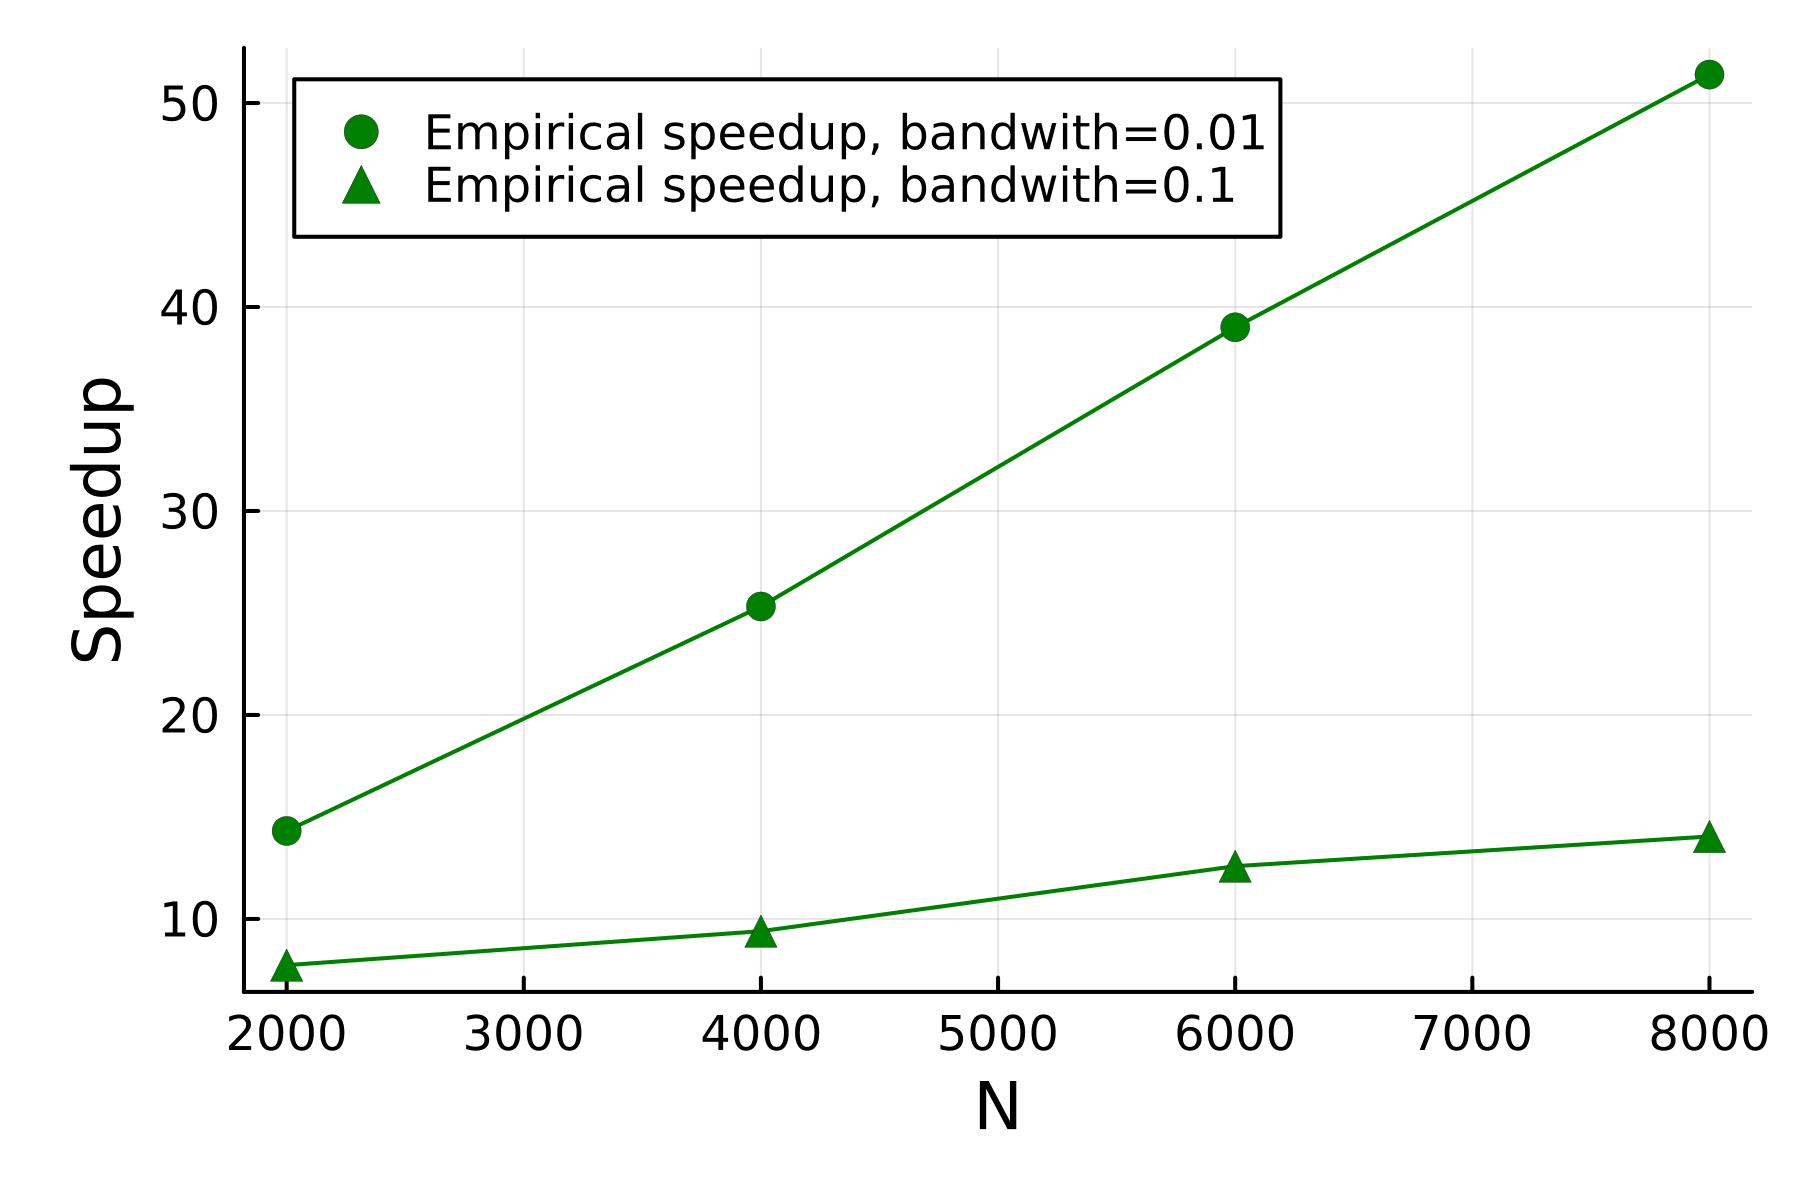

In [ ]:
Ns = 2_000:2_000:8_000
plot()
ms = [:circle, :utriangle]
for (i,b) in enumerate([0.01, 0.1])
  ts1 = [median(benchmarks_salu_bid[(b, n)].times) for n in Ns]
  ts2 = [median(benchmarks_lu_bid[(b, n)].times) for n in Ns]
  plot!(Ns, ts2./ts1, color=:green, label="")
  scatter!(Ns, ts2./ts1; label="Empirical speedup, bandwith=$b",
           thickness_scaling = 1.35,
           markersize = 4,
           markerstrokewidth = 0.1,
           markerstrokecolor = :black,
           markershape = ms[i],
           markercolor = :green)
end
plot!(dpi = 300, xlabel="N", ylabel="Speedup", legend=:topleft)


## Empirical Slowdown

In [ ]:
benchmarks_salu_did = Dict()
benchmarks_lu_did = Dict()
Ns = 2_000:2_000:8_000
bandwiths = [0.01, 0.1]
for b in bandwiths
  for n in Ns
    A_dense_in_dense = rand(n,n)

    # Benchmark structure_aware_lu
    t = @elapsed structure_aware_lu(A_dense_in_dense)
    b_salu_did = @benchmark structure_aware_lu($A_dense_in_dense) seconds=50t
    benchmarks_salu_did[(b, n)] = b_salu_did

    # Benchmark lu
    t = @elapsed lu(A_dense_in_dense)
    b_lu_did = @benchmark lu($A_dense_in_dense) seconds=50t
    benchmarks_lu_did[(b, n)] = b_lu_did
  end
end

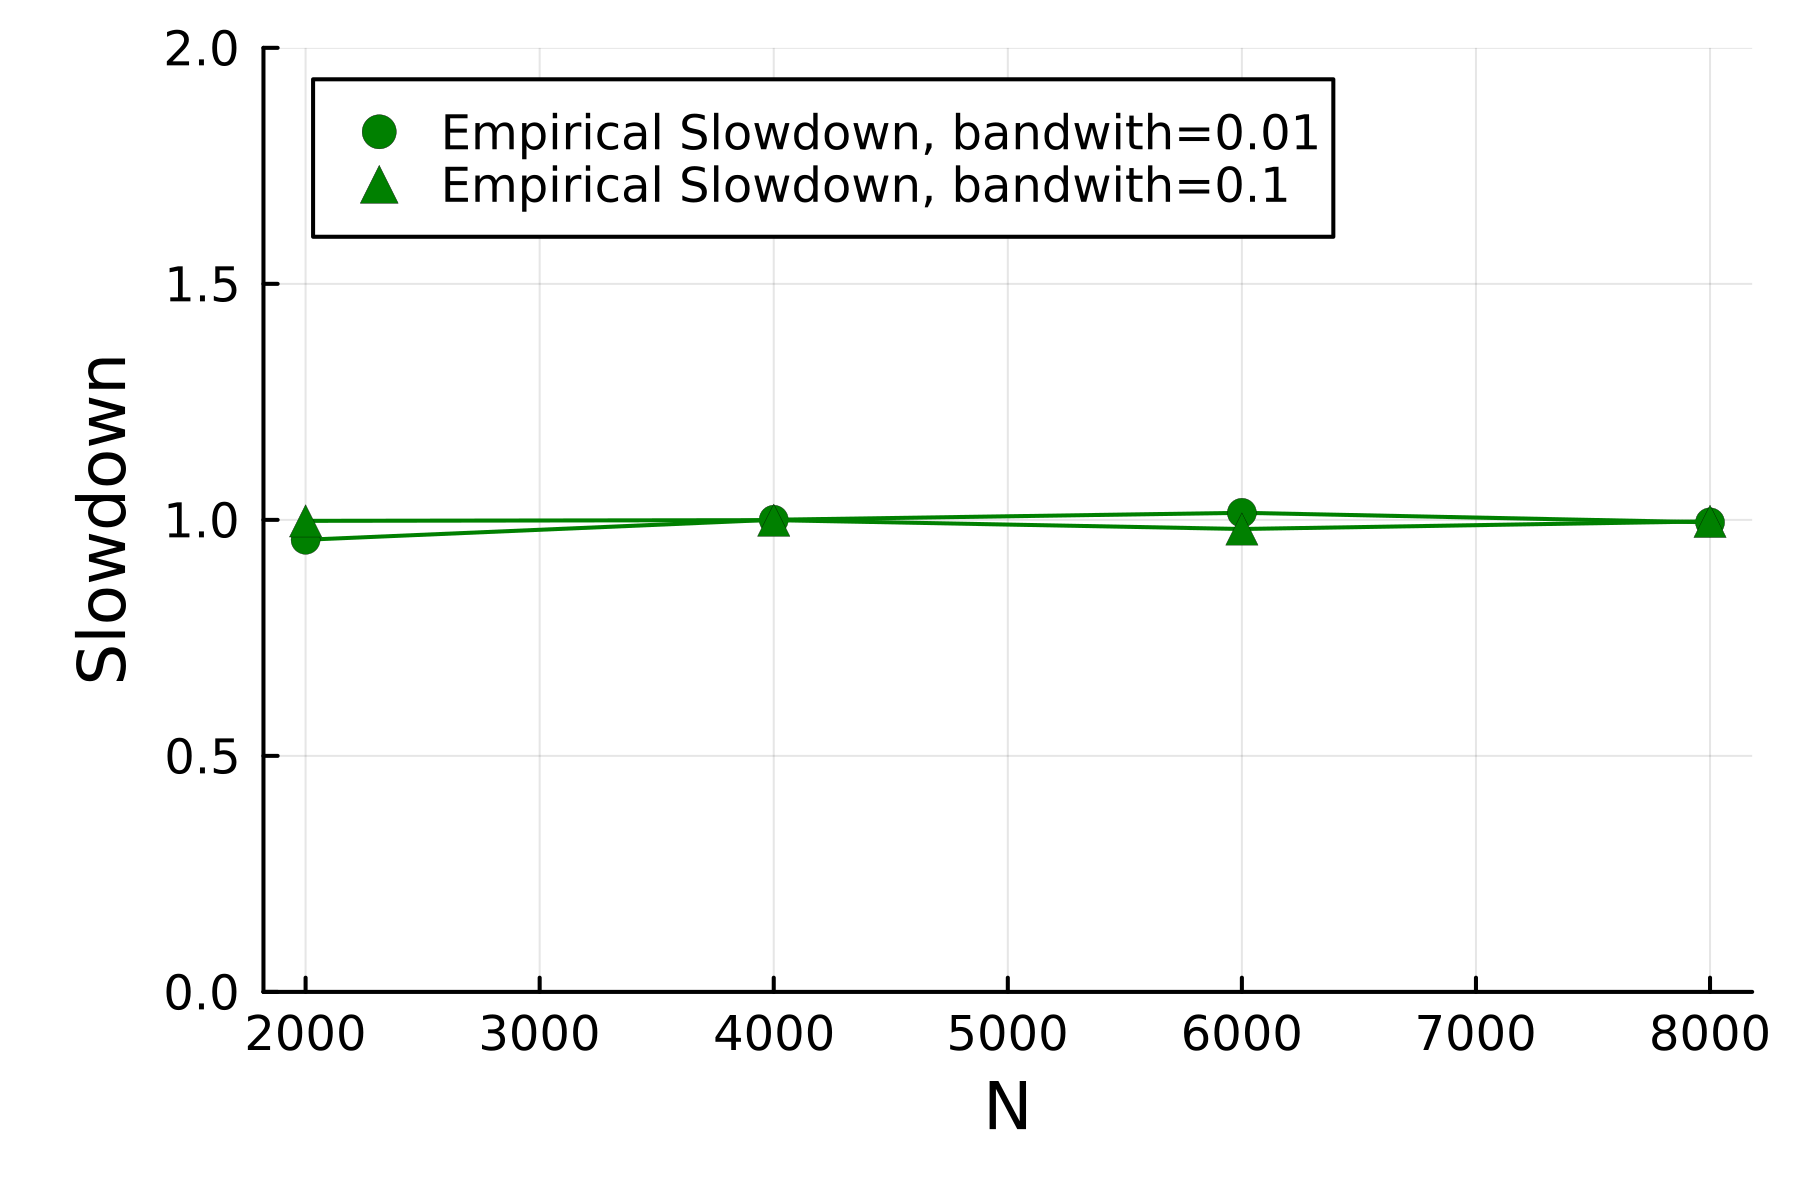

In [ ]:
Ns = 2_000:2_000:8_000
plot()
ms = [:circle, :utriangle]
for (i,b) in enumerate([0.01, 0.1])
  ts1 = [median(benchmarks_salu_did[(b, n)].times) for n in Ns]
  ts2 = [median(benchmarks_lu_did[(b, n)].times) for n in Ns]
  plot!(Ns, ts2./ts1, color=:green, label="")
  scatter!(Ns, ts2./ts1; label="Empirical Slowdown, bandwith=$b",
           thickness_scaling = 1.35,
           markersize = 4,
           markerstrokewidth = 0.1,
           markerstrokecolor = :black,
           markershape = ms[i],
           markercolor = :green)
end
plot!(dpi = 300,  ylims=(0, 2),
      xlabel="N", ylabel="Slowdown", legend=:topleft)

# Time and memory benchmarks

In [ ]:
n = 10_000
# Banded matrix in a dense structure
A_banded_in_dense = Matrix(brand(n,n,100,100))
# Dense matrix in a dense structure
A_dense_in_dense = copy(A_banded_in_dense)
A_dense_in_dense[1,n] = 1

1

In [ ]:
@benchmark lu($A_banded_in_dense) seconds=700

BenchmarkTools.Trial: 30 samples with 1 evaluation per sample.
 Range (min … max):  22.616 s …   24.037 s  ┊ GC (min … max): 0.17% … 0.16%
 Time  (median):     23.759 s               ┊ GC (median):    0.17%
 Time  (mean ± σ):   23.542 s ± 418.994 ms  ┊ GC (mean ± σ):  0.23% ± 0.26%

                                                 ██            
  ▄▁▁▁▄▄▁▁▁▇▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄▁▁▁▄▄▁▁▁▁▄▁▁▁▁▁▁▁▁▁▁▄▄██▇▄▁▄▁▁▁▁▁▇ ▁
  22.6 s          Histogram: frequency by time           24 s <

 Memory estimate: 763.02 MiB, allocs estimate: 4.

In [ ]:
@benchmark structure_aware_lu($A_banded_in_dense) seconds=15

BenchmarkTools.Trial: 36 samples with 1 evaluation per sample.
 Range (min … max):  389.014 ms … 614.902 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     402.753 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   427.128 ms ±  62.376 ms  ┊ GC (mean ± σ):  0.02% ± 0.08%

  █ ▁▃                                                           
  █▇██▇▁▄▁▇▄▄▁▁▄▁▁▄▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▆▁▁▁▄ ▁
  389 ms           Histogram: frequency by time          615 ms <

 Memory estimate: 68.97 MiB, allocs estimate: 13.

In [ ]:
@benchmark lu($A_dense_in_dense) seconds=700

BenchmarkTools.Trial: 30 samples with 1 evaluation per sample.
 Range (min … max):  22.754 s …   24.042 s  ┊ GC (min … max): 0.29% … 1.50%
 Time  (median):     23.738 s               ┊ GC (median):    0.17%
 Time  (mean ± σ):   23.580 s ± 356.503 ms  ┊ GC (mean ± σ):  0.23% ± 0.25%

                              ▁               █▁▄█  ▁          
  ▆▁▆▁▁▁▁▆▁▆▁▁▁▁▁▆▁▁▁▁▆▁▁▁▁▆▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆████▆▁█▆▁▆▁▁▁▁▆ ▁
  22.8 s          Histogram: frequency by time           24 s <

 Memory estimate: 763.02 MiB, allocs estimate: 4.

In [ ]:
@benchmark structure_aware_lu($A_dense_in_dense) seconds=350

BenchmarkTools.Trial: 15 samples with 1 evaluation per sample.
 Range (min … max):  22.833 s …   24.306 s  ┊ GC (min … max): 0.18% … 1.51%
 Time  (median):     23.923 s               ┊ GC (median):    0.17%
 Time  (mean ± σ):   23.768 s ± 421.177 ms  ┊ GC (mean ± σ):  0.26% ± 0.36%

  █                          ▁▁           ▁ ▁█▁██▁          ▁  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁██▁▁▁▁▁▁▁▁▁▁▁█▁██████▁▁▁▁▁▁▁▁▁▁█ ▁
  22.8 s          Histogram: frequency by time         24.3 s <

 Memory estimate: 763.02 MiB, allocs estimate: 5.